# Model two sine waves with same amplitude, frequency, but phase offset.

In [23]:
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
from jax.lax import cond
import numpyro
from numpyro.infer import NUTS, MCMC
from numpyro.distributions import Uniform
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from emcee.autocorr import integrated_time
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

In [2]:
# load samplers
import sys
import os

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from samplers.ptmcmc import ptmcmc_sampler

## Simulate data

We model the signal in the time-domain with two sine waves. The two waves have shared amplitude and frequency offset by a phase difference.

\begin{equation}
    h(t) = A\sin(2\pi f t) + A\sin(2\pi f t - \Delta\phi)
\end{equation}

The noise is normally distributed with zero-mean and fixed variance, $n_i\sim\mathcal{N}(0, \sigma^2)$.

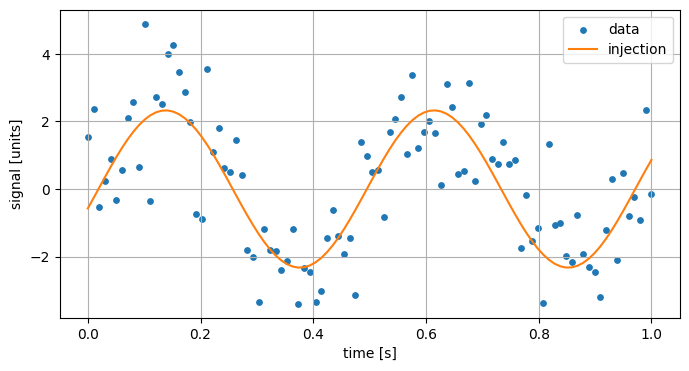

In [3]:
# time samples
Nt = 100
times = jnp.linspace(0., 1., Nt)

# define two-wave model
def model(amp, freq, phase_offset):
    wave_one = amp * jnp.sin(2. * jnp.pi * freq * times)
    wave_two = amp * jnp.sin(2. * jnp.pi * freq * times - phase_offset)
    return wave_one + wave_two
fast_model = jit(model)
vectorized_model = jit(vmap(fast_model))

# injected parameters
amp_inj = 1.2
freq_inj = 2.1
phase_offset_inj = np.pi / 6.3
sigma_inj = 1.3
x_inj = jnp.array([amp_inj, freq_inj, phase_offset_inj, sigma_inj])
ndim = x_inj.shape[0]

# simulate signal and noise
signal_inj = fast_model(amp_inj, freq_inj, phase_offset_inj)
noise = jr.normal(jr.key(0), (Nt,)) * sigma_inj
data = signal_inj + noise

# plot time-domain data and signal
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', s=15, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.grid()
plt.legend()
plt.show()

## Prior, likelihood, and posterior formulation

We use a uniform prior over signal and noise parameters, $\mathbf{x} = (A,\,f,\,\Delta\phi,\,\sigma)$. The likelihood is

\begin{equation}
    p(\mathbf{d}|\mathbf{x}) \propto \frac{1}{\sigma^{N_t}}\;\text{exp}\bigg[-\frac{1}{2\sigma^2}|\mathbf{d} - \mathbf{h}(t)|^2\bigg]
\end{equation}

In [4]:
# parameter bounds
x_mins = jnp.array([0., 0., -jnp.pi, 0.])
x_maxs = jnp.array([10., 10., jnp.pi, 10.])

# parameter labels
x_labels = np.array([r'$A$', r'$f$', r'$\Delta\phi$', r'$\sigma$'])

# uniform prior
def lnprior(x):
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_lnprior = jit(lnprior)

In [5]:
# likelihood
def lnlike(x):
    model_params = x[:-1]
    sigma = x[-1]
    residuals = data - fast_model(*model_params)
    return -0.5 * jnp.sum(residuals**2.) / sigma**2 - Nt * jnp.log(sigma)
fast_lnlike = jit(lnlike)

In [6]:
# posterior
def lnpost(x):
    return fast_lnprior(x) + fast_lnlike(x)
fast_lnpost = jit(lnpost)
vectorized_lnpost = jit(vmap(fast_lnpost))

## Sample with MCMC

In [7]:
def sampling_model():
    x = jnp.array([numpyro.sample(x_label, Uniform(x_min, x_max))
                   for x_label, x_min, x_max in zip(x_labels, x_mins, x_maxs)])
    numpyro.factor('log_likelihood', fast_lnlike(x))

In [8]:
# do HMC with NUTS
num_samples = int(1e4)
num_warmup = 500

nuts_kernel = NUTS(sampling_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jr.key(1))
samples_dict = mcmc.get_samples()

# convert dictionary of samples to array
samples = np.array([samples_dict[x_label] for x_label in x_labels]).T

sample: 100%|██████████| 10500/10500 [00:02<00:00, 4543.80it/s, 7 steps of size 4.68e-01. acc. prob=0.91] 


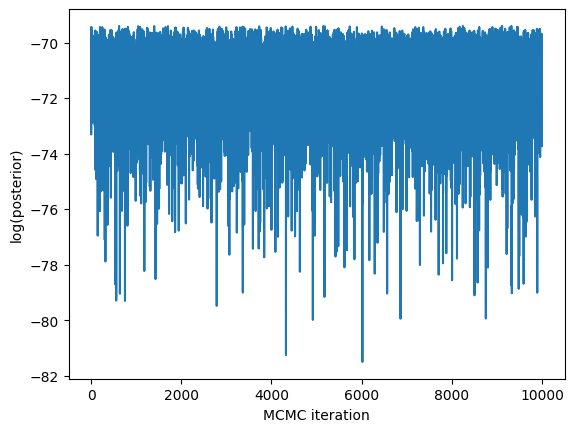

In [9]:
# plot likelihood values
lnposts = vectorized_lnpost(samples)
plt.plot(lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.show()

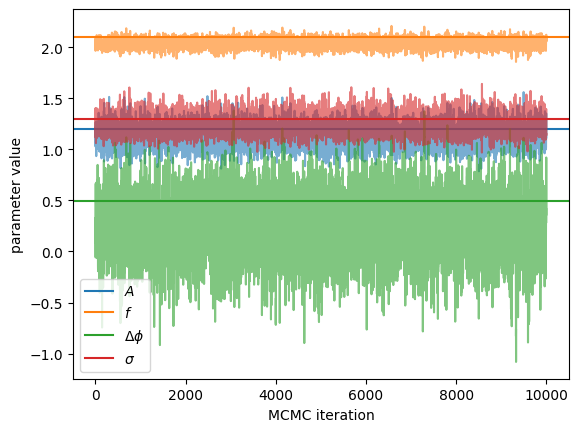

In [10]:
# trace plot
for i in range(ndim):
    plt.plot(samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(x_inj[i], color=f'C{i}', label=x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

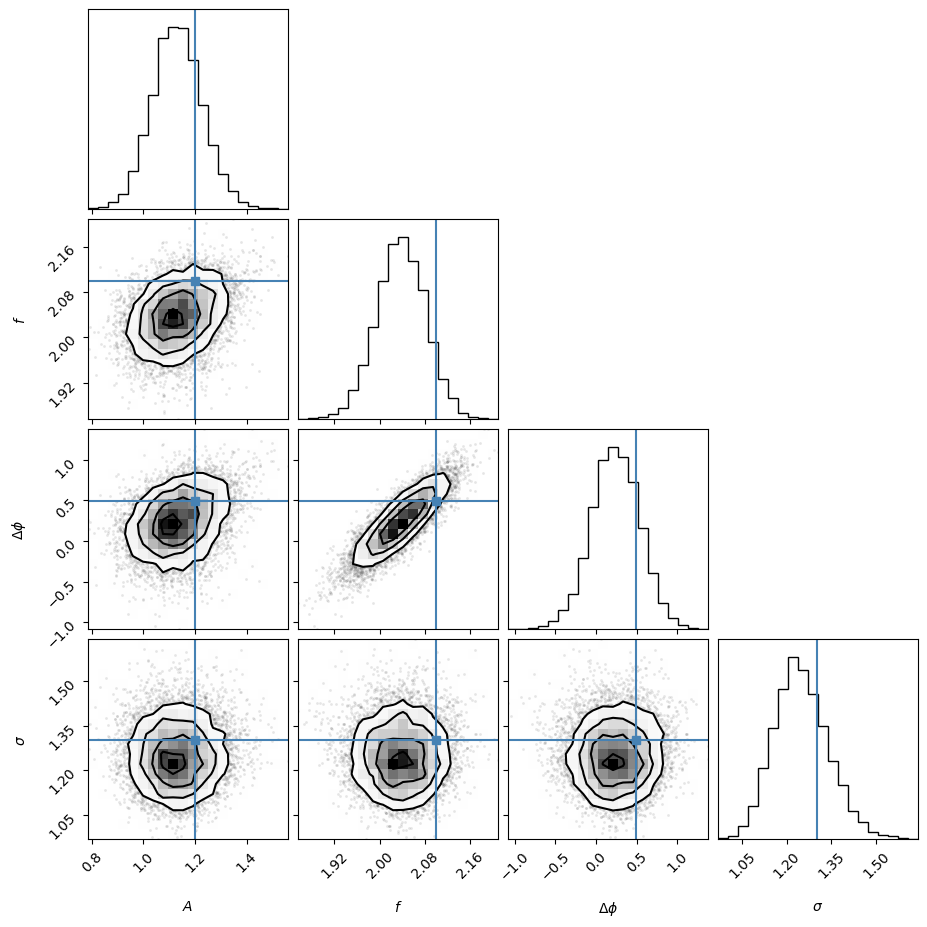

In [11]:
# corner plot
burnin = num_samples // 10
fig = corner(samples[burnin:],
             truths=x_inj,
             labels=x_labels)

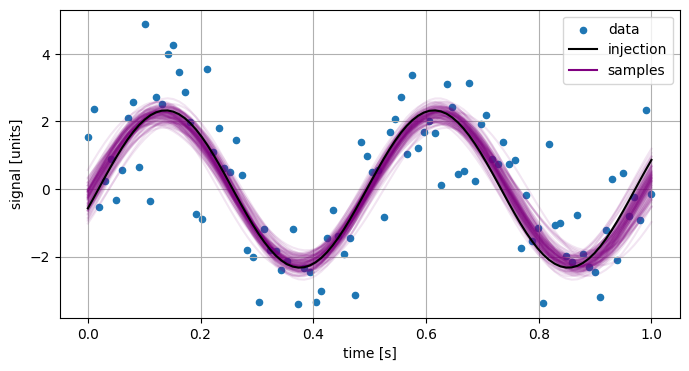

In [12]:
# Bayesogram
num_draws = 100
fair_draw_ndxs = np.random.choice(np.arange(burnin, num_samples), num_draws)
fair_samples = samples[fair_draw_ndxs, :-1]
signal_realizations = vectorized_model(*fair_samples.T)
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', s=20, label='data')
_ = [plt.plot(times, signal, color='purple', alpha=10./num_draws)
     for signal in signal_realizations]
plt.plot(times, signal_inj, color='k', label='injection')
plt.plot([], [], color='purple', label='samples')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [13]:
# posterior function with temperature input
def lnpost_pt(x, temperature=1.0):
    return fast_lnpost(x) / temperature
fast_lnpost_pt = jit(lnpost_pt)

In [14]:
num_samples = int(1e6)
num_chains = 50
samples, lnposts, temp_ladder = ptmcmc_sampler(num_samples,
                                               num_chains,
                                               fast_lnpost_pt,
                                               x_inj,
                                               Fisher_jump_weight=20,
                                               DE_jump_weight=20,
                                               PT_swap_weight=20,
                                               seed=0)

jump acceptance rates

Fisher: [0.53300005 0.535      0.537      0.54200006 0.55       0.56100005
 0.587      0.638      0.693      0.731      0.75000006 0.76000005
 0.76900005 0.777      0.77900004 0.781      0.77800006 0.77400005
 0.76400006 0.754      0.73800004 0.72200006 0.698      0.674
 0.646      0.61700004 0.58400005 0.54800004 0.512      0.47700003
 0.44000003 0.40300003 0.365      0.33100003 0.29900002 0.26900002
 0.24000001 0.215      0.19100001 0.17       0.15100001 0.134
 0.11700001 0.104      0.09200001 0.081      0.07       0.062
 0.055      0.048     ]

DE: [0.497      0.53800005 0.57900006 0.62100005 0.66300005 0.70400006
 0.735      0.749      0.74700004 0.75200003 0.76400006 0.78200006
 0.80500007 0.82800007 0.84700006 0.86600006 0.88000005 0.892
 0.901      0.91       0.91700006 0.92200005 0.92600006 0.93000007
 0.93200004 0.93500006 0.93700004 0.93900007 0.94100004 0.94200003
 0.943      0.94400007 0.94400007 0.94500005 0.94600004 0.94600004
 0.94600004 0.947     

In [15]:
# transpose samples and posterior values so (num_chains, num_samples,)
samples = np.transpose(samples, (1, 0, 2))
lnposts = np.transpose(lnposts, (1, 0))
print(samples.shape)

(50, 1000000, 4)


In [18]:
auto_correlation = integrated_time(samples[0])
effective_sample_size = samples[0].shape[0] // auto_correlation
print(f'auto-correlation = {auto_correlation}')
print(f'effective sample size = {effective_sample_size}')

auto-correlation = [10.2561354]
effective sample size = [97502.]


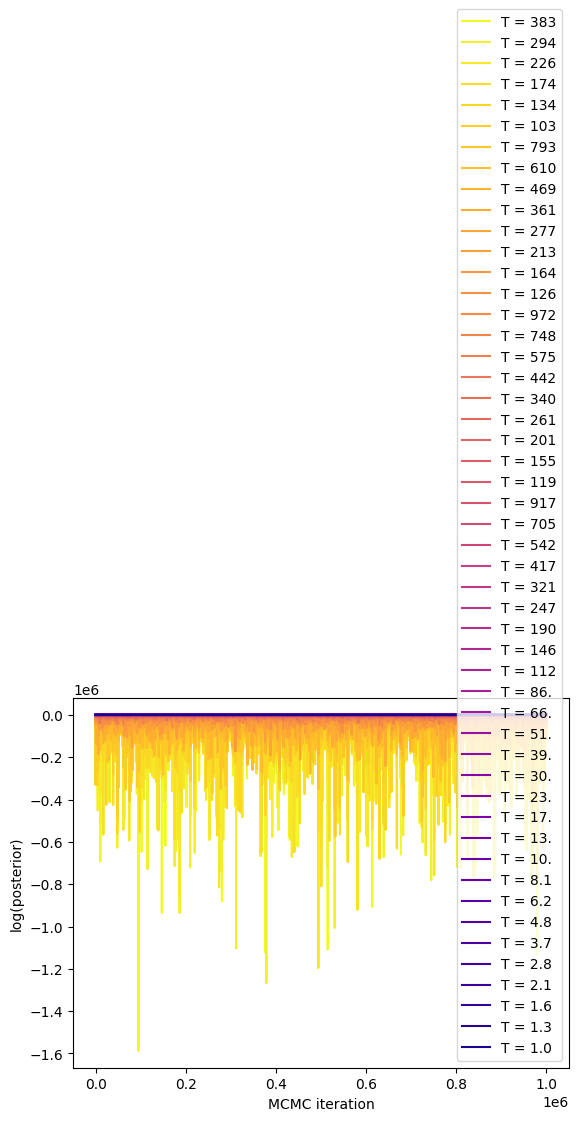

In [19]:
# plot likelihood values of chains (without temperature scaling)
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))

for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(lnposts[::-1][j] * temp, color=color, label=f'T = {str(temp)[:3]}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.legend(loc='lower right')
plt.show()

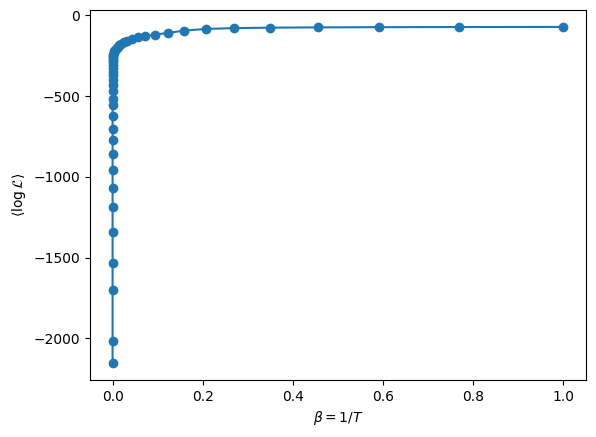

In [22]:
# average log-likelood over temperatures
burnin = num_samples // 5
avg_lnlikes = np.mean(lnposts[:, burnin::int(auto_correlation[0])], axis=1) * temp_ladder
betas = 1. / temp_ladder
plt.plot(betas, avg_lnlikes, marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle\log\mathcal{L}\rangle$')
plt.show()

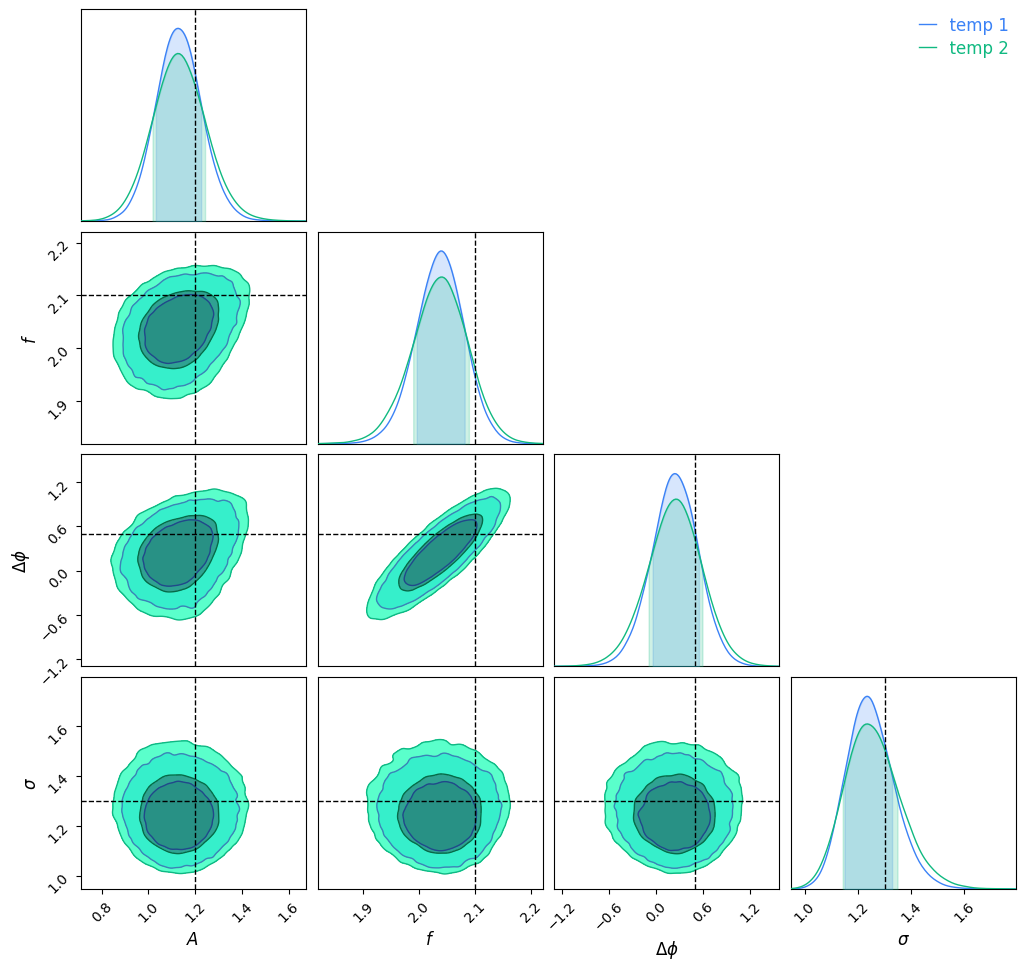

In [25]:
df1 = pd.DataFrame(samples[0, burnin::int(auto_correlation[0])], columns=x_labels)
df2 = pd.DataFrame(samples[1, burnin::int(auto_correlation[0])], columns=x_labels)

c = ChainConsumer()
c.add_chain(Chain(samples=df1, name='temp 1'))
c.add_chain(Chain(samples=df2, name='temp 2'))
c.add_truth(Truth(location={x_label: x_val for x_label, x_val in zip(x_labels, x_inj)}))
fig = c.plotter.plot(range)